In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

import json
import enum
import os

from col_mnist import ColMNIST
from three_d_shapes_ds import ThreeDShapes
from models import compute_layer_blocks_out


class SupportedDatasets(enum.Enum):
    THREEDSHAPES = 0,
    COL_MNIST = 1,
    CIFAR10 = 2

In [2]:
MODEL_DIR = "outputs/28.09.2021(14:21:35)"
vgg16 = torch.load(os.path.join(MODEL_DIR, "model.pt"))
layer = vgg16.classifier[0]
layer_size = layer.out_features
ncc = vgg16.classifier[2].n_conn_comp
blocks = compute_layer_blocks_out(layer, ncc)
ds = SupportedDatasets.COL_MNIST
filtered = False

In [3]:
if not os.path.exists(os.path.join(MODEL_DIR, "visualizations")):
    os.mkdir(os.path.join(MODEL_DIR, "visualizations"))

In [4]:
if ds == SupportedDatasets.THREEDSHAPES:
    trainloader = torch.utils.data.DataLoader(
                                          ThreeDShapes(filename='data/3dshapes.h5',
                                                       transform=torchvision.transforms.Compose([
                                                           torchvision.transforms.ToPILImage(), 
                                                           torchvision.transforms.Resize((32, 32)),
                                                           torchvision.transforms.ToTensor(),
                                          ]), filtered = filtered),
                                          batch_size=32, shuffle=True)
    testloader = torch.utils.data.DataLoader(
                                          ThreeDShapes(filename='data/3dshapes.h5',
                                                       transform=torchvision.transforms.Compose([
                                                           torchvision.transforms.ToPILImage(), 
                                                           torchvision.transforms.Resize((32, 32)),
                                                           torchvision.transforms.ToTensor(),
                                          ]), filtered = filtered),
                                          batch_size=32, shuffle=True)
elif ds == SupportedDatasets.COL_MNIST:
    trainloader = torch.utils.data.DataLoader(
      ColMNIST('data/mnist', train=True, download=True,
                                 transform=torchvision.transforms.Compose([#torchvision.transforms.Resize((224, 224)),
                                   torchvision.transforms.ToTensor(),
                                 ])),
      batch_size=32, shuffle=True)

    testloader = torch.utils.data.DataLoader(
      ColMNIST('data/mnist', train=False, download=True,
                                 transform=torchvision.transforms.Compose([#torchvision.transforms.Resize((224, 224)),
                                   torchvision.transforms.ToTensor()
                                 ])),
      batch_size=32, shuffle=True)

elif ds == SupportedDatasets.CIFAR10:
    transform = transforms.Compose(
        [transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                            shuffle=True)
    testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                            shuffle=False)
    n_classes = 10
    def target_vec_to_class(x):
        return x

In [5]:
#find activations for images
class SaveOutput:
    def __init__(self):
        self.outputs = None
        
    def __call__(self, module, module_in, module_out):
        self.outputs = module_out.detach().cpu().numpy()

hook = SaveOutput()
layer.register_forward_hook(hook)
act = np.zeros((0, layer_size))

def target_vec_to_class(tpl):
    (target, dclr_idx, bclr_idx) = tpl
    target += bclr_idx*10
    return target.long()

for i, data in enumerate(testloader):
    print(i, end="\r")
    data, target = data[0], data[1]
    target = target_vec_to_class(target)
    print(target)
    data = data.cuda()
    output = vgg16(data)
    act = np.concatenate((act, hook.outputs), axis=0)
    if i > 1000:
        break
    
img_shape = data[0].shape
target_shape = target[0].shape

tensor([23, 13, 25, 17, 26,  3, 21, 22, 14, 23,  1, 10,  0, 14, 12, 10,  8, 26,
        20,  9, 12,  6, 12, 20,  6,  4, 18, 12, 20, 20,  2, 21])
tensor([19,  5, 27,  9, 14,  1,  7,  9, 25,  0,  9, 18, 20,  4, 14, 15, 28,  9,
        21, 15, 24,  5,  3,  6, 27, 15,  1, 23, 29, 22,  6,  7])
tensor([28, 16, 19, 14, 11, 15, 22, 15, 18,  7, 12, 15,  4, 28, 19,  4, 10, 16,
        25, 10, 27, 15,  7, 27, 29, 28, 17, 14, 11, 24,  7,  8])
tensor([ 1, 12, 25, 13, 25, 21, 23,  8,  5, 24, 10, 11,  1, 18,  8,  0, 23, 29,
        17, 24,  3, 22,  2,  9, 18, 15,  5,  9,  1,  8,  0, 17])
tensor([25, 27,  1,  4,  3,  4, 12, 29, 14, 28, 13,  0, 19, 16, 19, 19,  1, 23,
         5,  4, 26,  6,  9, 27,  0, 28, 12,  1, 26, 18,  0,  5])
tensor([25,  5, 21, 17, 28,  0, 21, 16,  9, 20,  5,  3,  9,  0, 10, 22,  0, 26,
        24, 11,  9, 25,  3, 26, 24, 27,  3, 20, 11, 29, 20, 25])
tensor([11,  5, 10,  0, 25, 18, 29, 22, 26, 29,  9, 20, 28, 21, 21, 20, 24, 22,
        14, 18,  0, 19,  5,  2,  9,  7, 28, 15, 14

tensor([23,  7, 19, 12, 26, 23, 12, 12, 27, 29,  9,  9,  9,  3,  1, 26, 21, 13,
        16,  8, 22,  3,  3, 19, 27,  5, 14,  9, 19,  6,  8, 16])
tensor([ 1,  5,  3, 17, 26,  2,  9, 17, 19,  5, 10, 10, 24,  7,  1, 21, 28,  4,
         9, 12,  4,  1,  6, 27,  8, 14, 18, 11,  1,  9,  2, 29])
tensor([ 7, 13,  5, 27, 23, 25,  5,  2, 19, 17, 23, 17,  9, 17, 29, 27,  6, 22,
         1,  7,  3,  2, 10, 22, 22, 13,  3, 21,  8, 20,  2,  2])
tensor([ 8, 17,  2, 25, 28, 18,  7, 23, 22, 10, 13, 19, 26,  2, 17, 25, 12, 12,
        21, 22,  9,  2, 19,  0, 27, 14, 27, 13,  7,  0, 10, 25])
tensor([ 0, 11, 25, 12, 20, 18, 13, 16, 11,  3, 16, 10,  1, 29,  6, 23, 20, 17,
         5, 13, 21, 27, 17, 22, 22, 17,  9, 21, 22, 22, 23, 22])
tensor([14, 26, 25, 19,  9, 16,  7, 12, 20, 25,  2, 22, 14, 29, 22,  0, 13,  6,
        26, 19, 25, 14, 11, 22,  7,  2, 17,  2, 26, 23, 13, 19])
tensor([19,  6, 26, 17,  7, 15,  6, 20, 13,  1,  5, 25, 11,  9,  3,  0,  7, 25,
        27, 19,  9,  8,  6, 25,  7,  1, 14,  8,  8

tensor([27,  0, 20, 14, 12, 19,  3,  8, 17, 14, 13, 23, 29, 29, 16, 10, 13, 20,
        10, 21, 28,  3, 17,  1,  5, 24, 19, 29,  0, 12, 14, 21])
tensor([14,  2, 26,  8, 29,  3, 19,  2,  8, 27, 20, 16,  3, 20, 12, 13, 28, 19,
        19, 24, 16, 28, 27,  6, 14, 20,  1,  6, 13, 25, 23,  1])
tensor([ 4,  5, 16, 11, 14,  8, 14,  4, 18,  2,  4, 10, 22, 19, 21,  3,  4, 16,
        11, 14,  6,  7, 22, 20,  6, 20, 13,  0, 13, 23,  5, 24])
tensor([20, 12, 28,  4, 25,  7, 17, 14, 13, 25,  0, 14, 23, 24, 28,  7, 14,  2,
         0, 27, 28, 10, 26,  0, 13, 17,  5,  4,  1, 17, 28, 25])
tensor([ 2, 24,  7,  3,  9, 15, 12, 27,  1,  1, 19, 12, 25,  9, 10, 15, 24,  1,
         0,  3, 11, 27, 27, 25,  1, 13, 28, 29, 12,  1,  5, 29])
tensor([ 3,  4, 21,  5,  9, 20,  8, 19, 23,  8, 19, 29, 10, 10, 17, 22,  2, 20,
        25,  4,  2, 17, 23, 15,  4,  7, 17,  6,  6, 21,  3, 24])
tensor([29, 12, 22, 21, 27, 26,  0,  0, 23, 20, 11, 29, 18, 28,  8, 25, 29,  9,
        20, 16, 17,  4, 16, 26, 26, 27, 20, 13,  1

tensor([ 1, 11, 17, 19, 14,  1,  1,  2,  0, 20, 21, 16, 22, 25, 11, 25,  5,  3,
        20, 16, 17, 20,  5,  5, 16,  7, 20, 18,  2, 20,  9,  0])
tensor([20,  8, 19, 24,  3, 21, 20, 23, 18, 27,  8,  2, 12, 11, 17, 18, 21,  1,
         6, 24, 17, 18,  5, 22, 19, 23, 15, 17, 23,  3, 23, 23])
tensor([18,  5, 14, 27, 12, 27,  2, 27, 20, 22,  6,  9,  5, 21, 12, 10, 25, 20,
        22,  3, 20, 20, 26,  6, 19,  1, 22,  0, 26,  4,  9, 20])
tensor([ 1,  8,  1, 29, 29,  0, 18, 10,  1, 26, 25, 21, 26,  6, 22, 29, 23,  4,
        18, 28,  8, 14, 21, 18, 26,  7, 21, 10,  4, 27, 23,  3])
tensor([23, 19,  3,  3, 27, 13, 22,  5, 22, 26, 25,  8,  7, 17,  6,  4,  6, 19,
        20,  7, 16, 12, 25, 27,  5,  7,  9,  4, 23, 13, 14, 21])
tensor([ 2, 19, 27, 18, 14,  3, 27, 10, 26, 16, 23,  2, 19, 16, 13,  9, 13, 19,
        16, 10,  1, 20, 17, 23, 14,  7,  9, 23, 12, 13, 20, 28])
tensor([ 5, 17, 22, 26, 21, 13,  6,  7,  3,  0, 20, 10, 19,  3, 26, 25, 20, 27,
        11, 20, 11,  1,  7,  0, 11, 23,  8,  1, 24

tensor([17, 11, 11, 29,  8,  2, 28, 11, 24, 17, 28,  8, 20, 22, 18,  4,  2,  4,
         6, 12, 19,  9,  5, 29, 15, 14, 23,  4,  9,  1,  2,  1])
tensor([21,  7, 26, 18, 16, 19, 26,  1, 17, 22, 22,  3, 16, 23,  7,  9,  3, 10,
         2,  0, 18, 13, 15, 12, 18, 11,  4, 17,  9, 18,  1, 25])
tensor([14, 26, 13, 20, 25, 26,  7, 16, 15, 14, 22, 21, 15,  5, 16, 13, 11, 23,
        17, 29,  7,  3, 19,  3, 23, 27, 12, 11, 20, 24, 23, 14])
tensor([20,  0,  9, 15, 12,  1, 21, 14, 20, 18,  2, 27, 27, 29, 11,  6, 16, 11,
        16, 21, 29, 19,  2, 12, 24,  0, 27, 22, 10,  2, 25, 10])
tensor([ 6, 10,  0, 20, 17, 18, 14,  9,  2, 22, 24, 24,  4, 29, 23,  9, 12, 23,
        17, 20, 19, 24,  5, 26, 15,  7, 21, 20, 13,  4, 29, 12])
tensor([24, 29,  9,  1,  5,  9,  6,  1, 25,  8, 24, 12, 21, 14, 25, 26, 27,  7,
        10,  4,  1, 15, 19, 29, 29, 11, 11,  9, 17,  0, 17, 20])
tensor([21, 12,  2, 11,  7, 12, 26, 28,  3,  6,  8, 20,  6,  1, 17,  0, 14, 12,
        29, 23,  4,  4,  9,  4, 12,  7,  8,  9,  7

In [6]:
target.shape

torch.Size([16])

In [7]:
thr_low = np.percentile(act, 5, axis=0)
thr_high = np.percentile(act, 95, axis=0)

In [8]:
#%pdb on

In [9]:
layer_size

400

In [10]:
#find activations for images
class SaveOutput:
    def __init__(self):
        self.outputs = None
        
    def __call__(self, module, module_in, module_out):
        self.outputs = module_out.detach().cpu().numpy()

hook = SaveOutput()
layer.register_forward_hook(hook)

weighted_images_pos = np.zeros((layer_size, *img_shape))
weighted_images_neg = np.zeros((layer_size, *img_shape))
targets_pos = [np.zeros((0, 30)) for i in range(layer_size)]
targets_neg = [np.zeros((0, 30)) for i in range(layer_size)]
img_examples_pos = [np.zeros((0, *img_shape)) for _ in range(layer_size)]
n_pos = np.zeros((layer_size))
n_neg = np.zeros((layer_size))

for i, data in enumerate(testloader):
    print(i, end="\r")
    if i > 1000:
        break
    data, target = data[0], data[1]
    data = data.cuda()
    output = vgg16(data)
    data = data.detach().cpu().numpy()

    batch_ext = np.repeat(data[:, np.newaxis, :, :], layer_size, axis=1)
    
    #print(weighted_images_pos.shape)
    #print(batch_ext.shape)
    weighted_images_pos += np.average(batch_ext * np.expand_dims((hook.outputs > thr_high), axis=(2, 3, 4)), axis=0)
    weighted_images_neg += np.average(batch_ext * np.expand_dims((hook.outputs < thr_low), axis=(2, 3, 4)), axis=0)
    n_pos += (hook.outputs > thr_high).sum(axis=0)/32
    n_neg += (hook.outputs < thr_low).sum(axis=0)/32
    #print(hook.outputs.shape)
    for j in range(hook.outputs.shape[0]):
        for k in range(layer_size):
            if hook.outputs[j, k].item() > thr_high[k]:
                img_examples_pos[k] = np.concatenate((img_examples_pos[k], data[j][np.newaxis, :,:, :]), axis=0)

    #targets of images that activated each neuron by more than the threshold
    #for j in range(layer_size):
       #print(target[hook.outputs[:,j] > thr_high[j]].shape)
       #targets_pos[j] = np.concatenate([targets_pos[j], target[hook.outputs[:,j] > thr_high[j]]], axis=0)
       #targets_neg[j] = np.concatenate([targets_neg[j], target[hook.outputs[:,j] < thr_low[j]]], axis=0)


In [11]:
#weighted_images_pos_norm = weighted_images_pos / np.expand_dims(np.max(weighted_images_pos, axis=(1, 2, 3)), axis=(1, 2, 3))
#weighted_images_neg_norm = weighted_images_neg / np.expand_dims(np.max(weighted_images_neg, axis=(1, 2, 3)), axis=(1, 2, 3))
weighted_images_pos_norm = weighted_images_pos/n_pos[:, np.newaxis, np.newaxis, np.newaxis]
weighted_images_neg_norm = weighted_images_neg/n_neg[:, np.newaxis, np.newaxis, np.newaxis]

/tmp/ipykernel_7801/338085884.py:3: RuntimeWarning: invalid value encountered in true_divide
  weighted_images_pos_norm = weighted_images_pos/n_pos[:, np.newaxis, np.newaxis, np.newaxis]
/tmp/ipykernel_7801/338085884.py:4: RuntimeWarning: invalid value encountered in true_divide
  weighted_images_neg_norm = weighted_images_neg/n_neg[:, np.newaxis, np.newaxis, np.newaxis]


In [12]:
_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


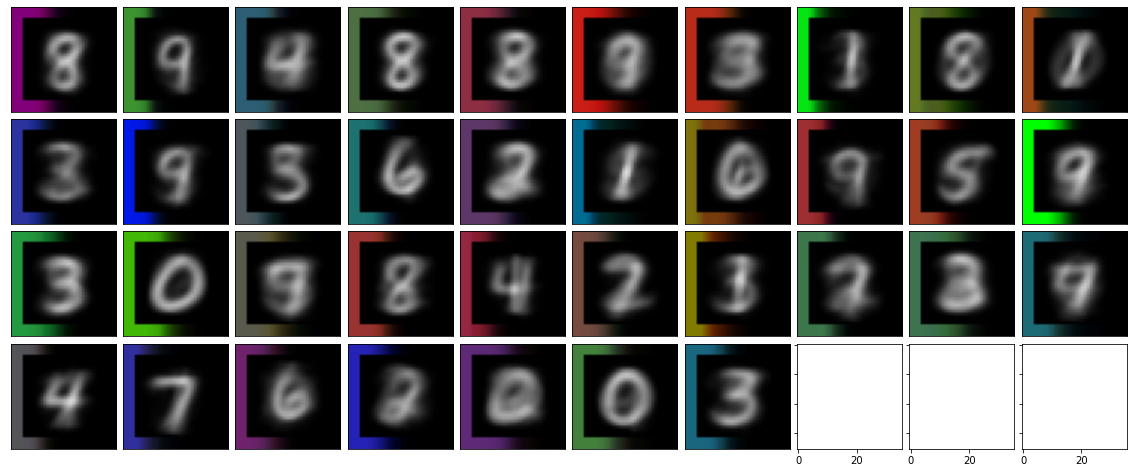

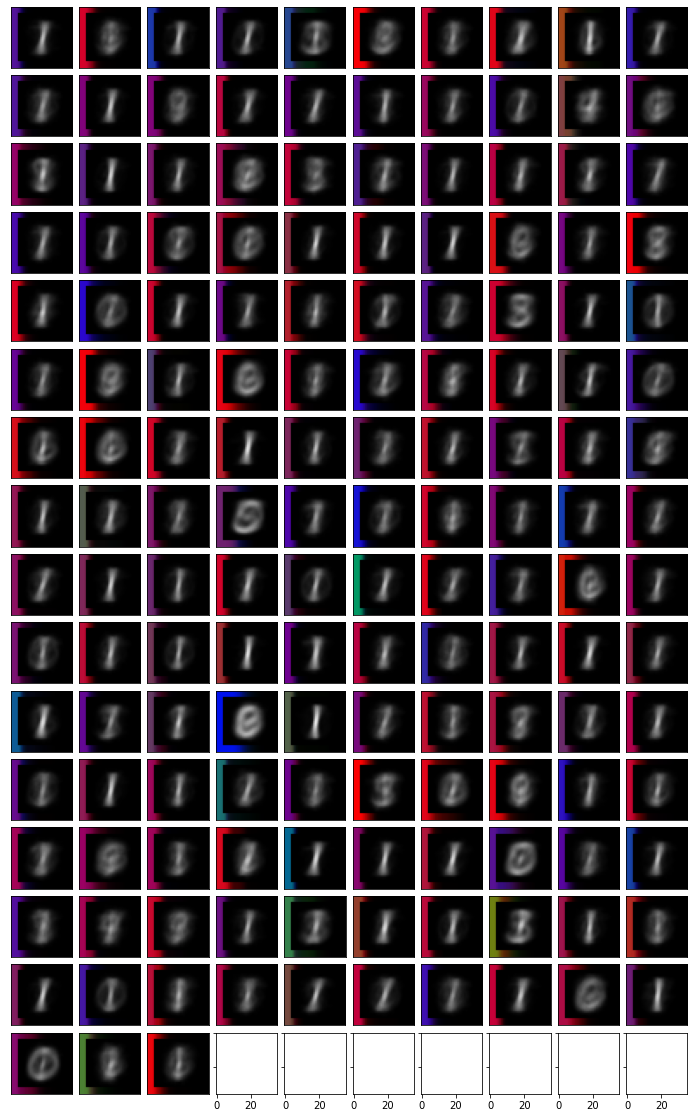

In [13]:
for c in range(ncc):
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(int(np.ceil((blocks==c).sum()/10)), 10),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                    )
                     
    for ax, im in zip(grid, weighted_images_pos_norm[blocks==c]):
        ax.imshow(im.transpose(1, 2, 0))
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    plt.show()
    fig.savefig(os.path.join(MODEL_DIR, "visualizations","block_{}_pos_imgs.png".format(c)))

floor_hue


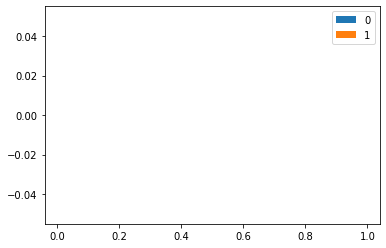

wall_hue


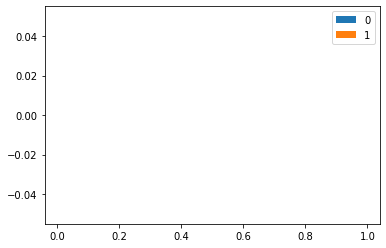

object_hue


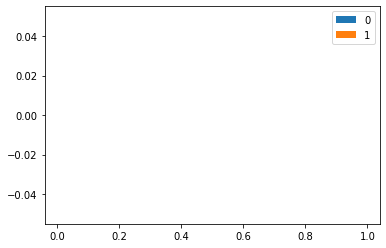

scale


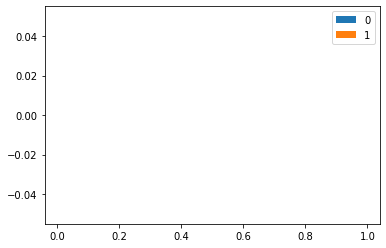

shape


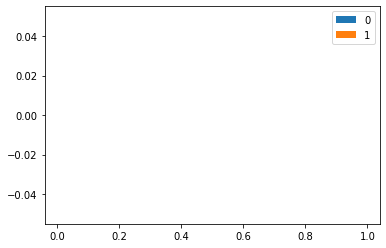

orientation


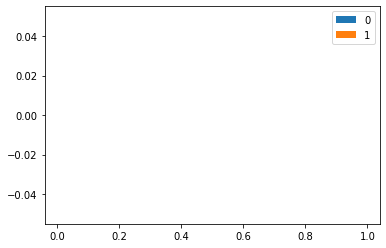

In [14]:
for i in range(6):
    print(_FACTORS_IN_ORDER[i])
    targets_pos_aggregate = list()
    for c in range(ncc):
        #print("Block {}".format(c+1))
        targets_pos_aggregate.append(np.zeros((0)))
        for j in range(layer_size):
            if blocks[j] == c:
                targets_pos_aggregate[c] = np.concatenate([targets_pos_aggregate[c], targets_pos[j][:, i]], axis=0)

    #print(targets_pos_aggregate)
    min_len = min(len(targets_pos_aggregate[c]) for c in range(ncc))
    targets_pos_aggregate_sample = [targets_pos_aggregate[c][:min_len] for c in range(ncc)]
    fig = plt.figure()
    plt.hist(np.array(targets_pos_aggregate_sample).transpose())
    plt.legend(range(ncc))
    plt.show()
    fig.savefig(os.path.join(MODEL_DIR, "visualizations","factor_{}_pos_factors_hist.png".format(i)))

Block 0


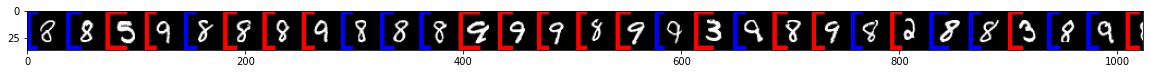

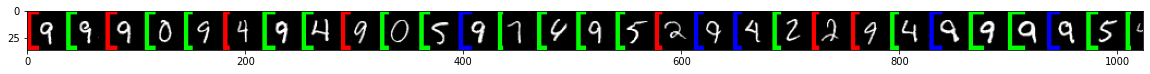

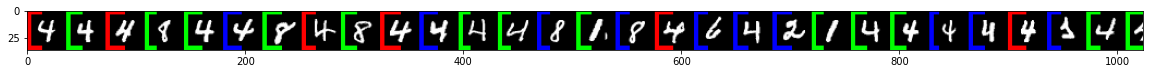

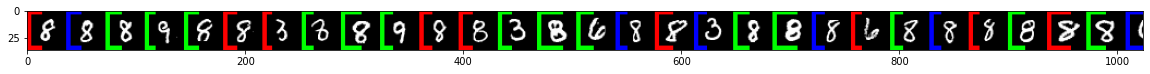

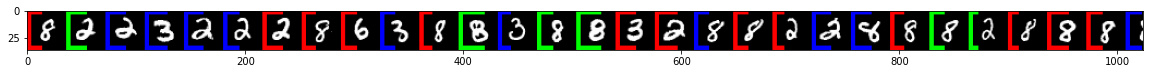

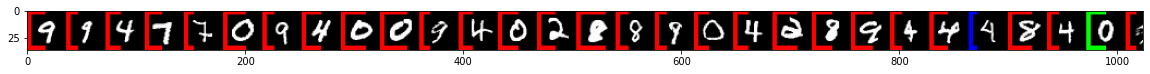

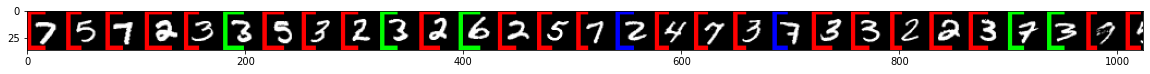

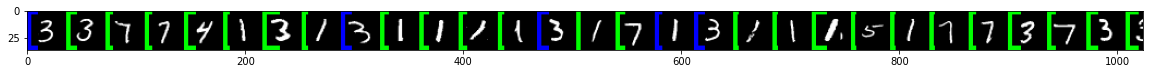

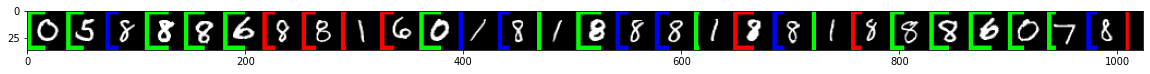

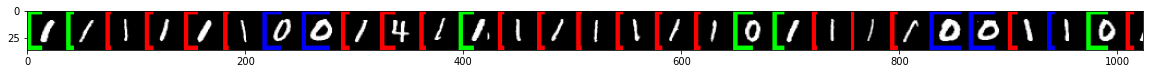

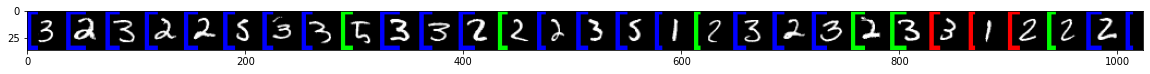

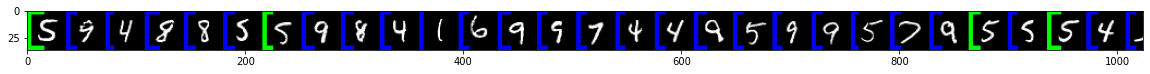

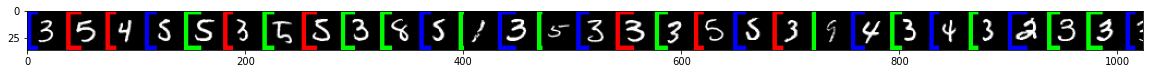

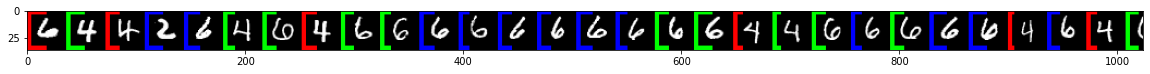

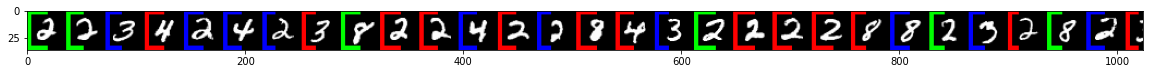

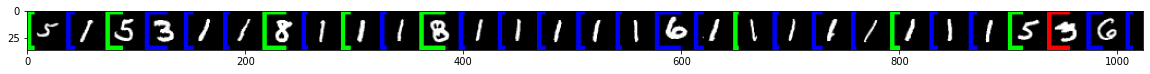

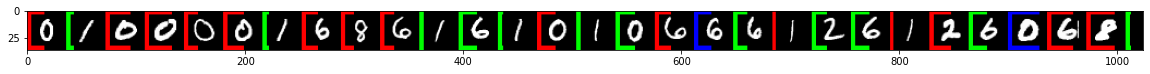

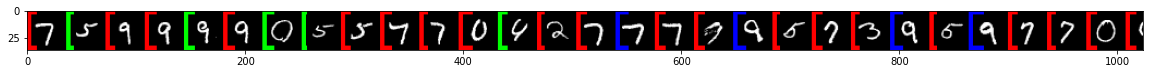

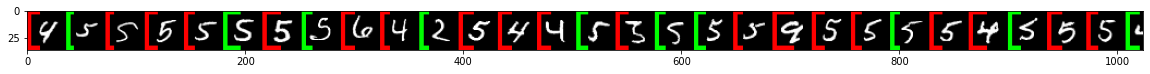

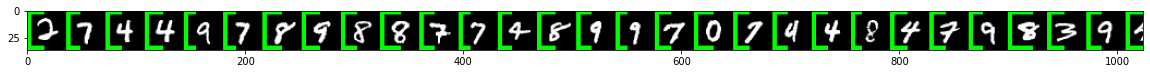

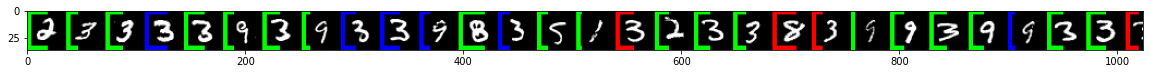

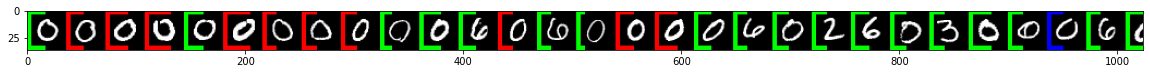

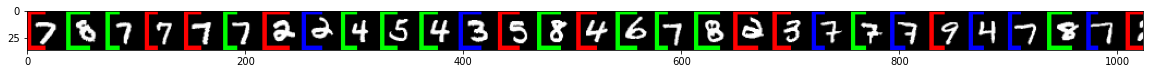

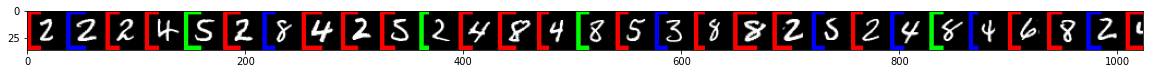

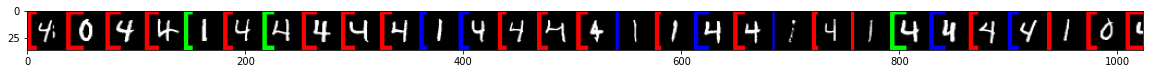

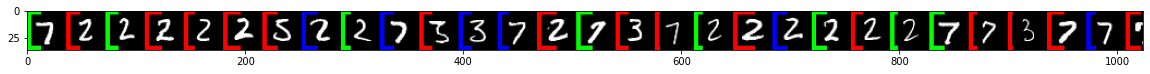

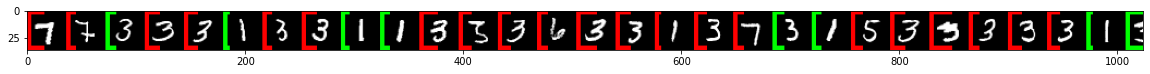

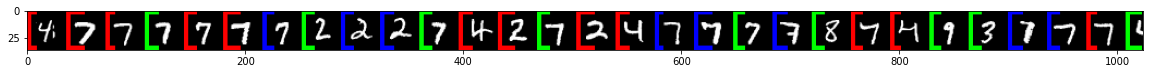

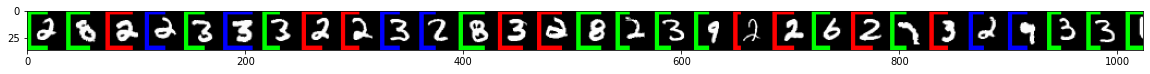

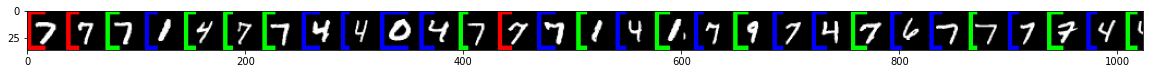

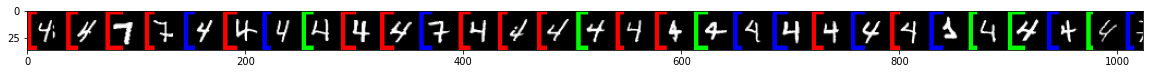

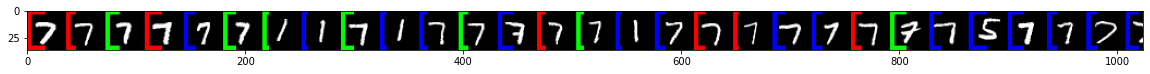

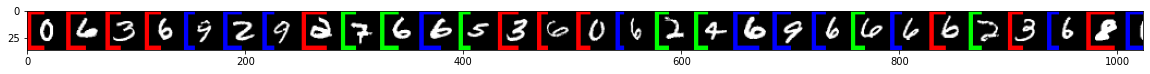

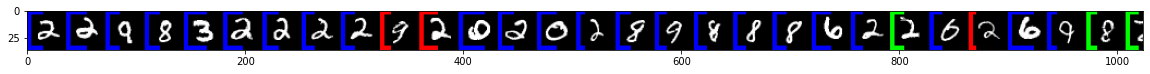

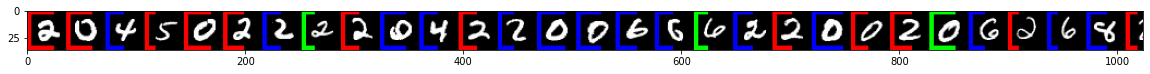

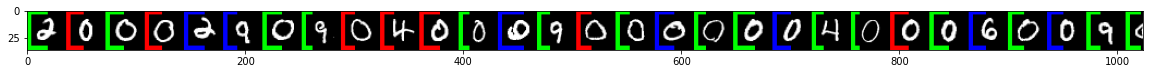

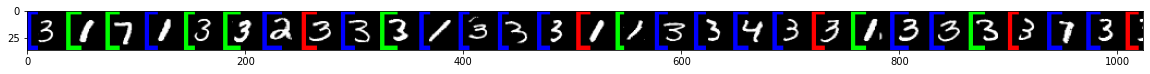

Block 1


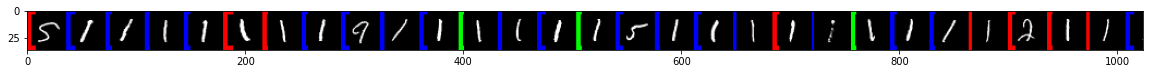

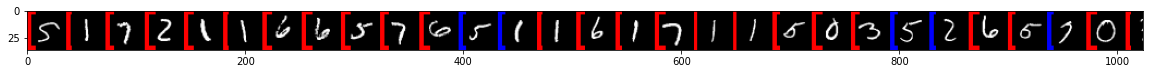

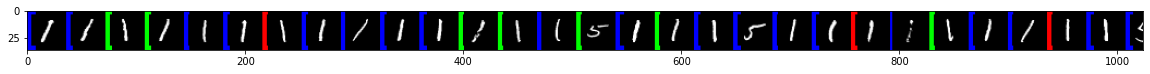

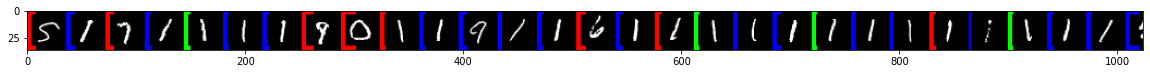

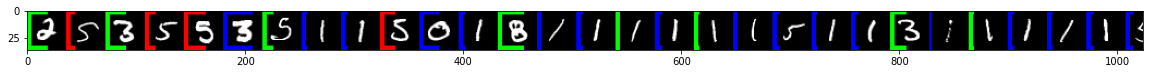

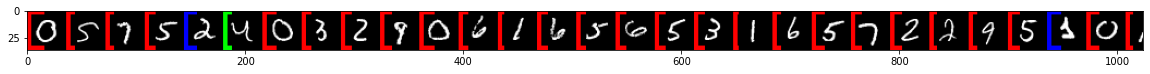

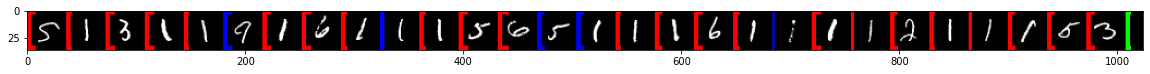

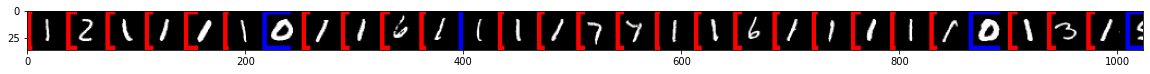

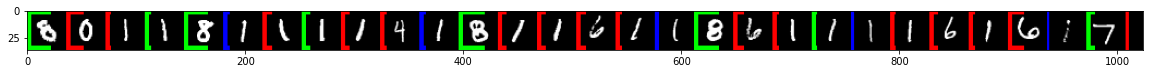

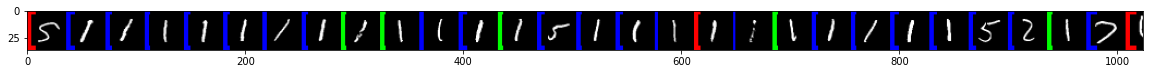

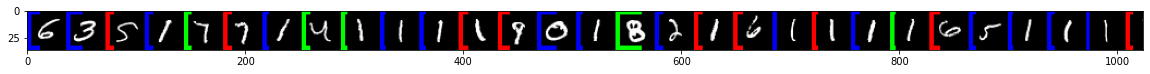

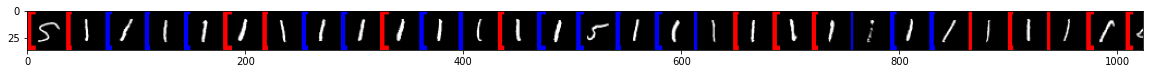

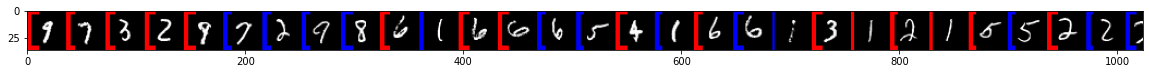

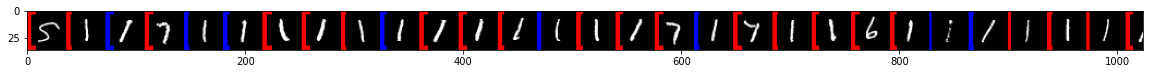

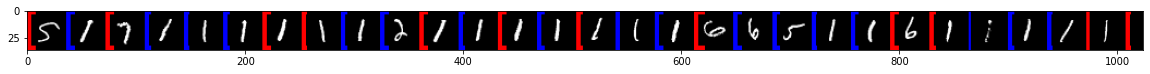

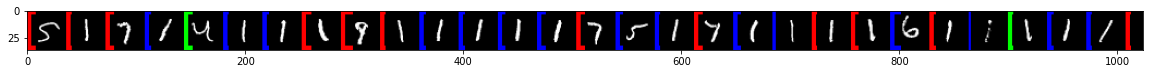

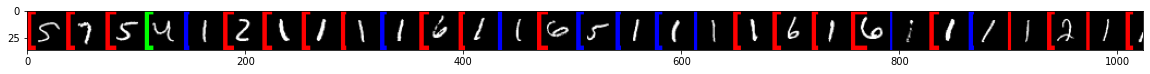

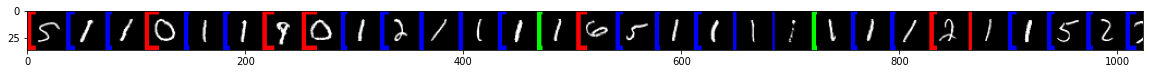

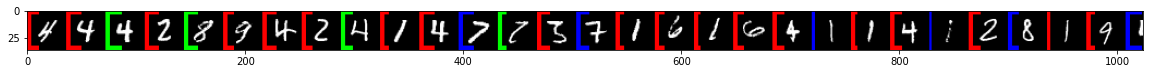

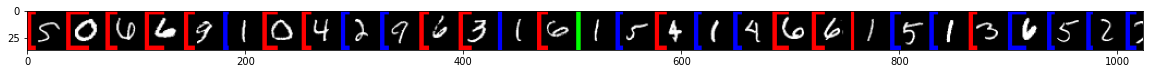

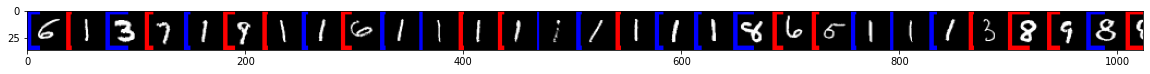

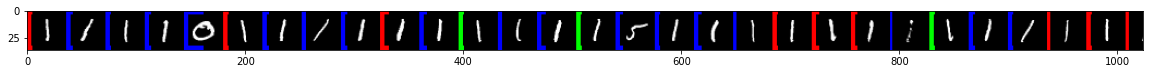

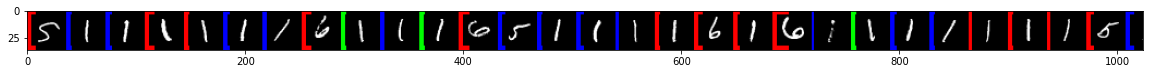

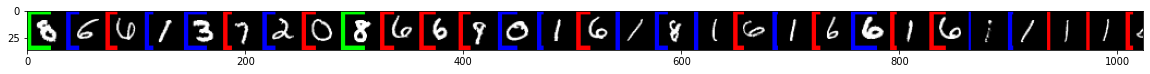

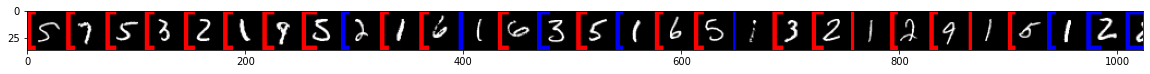

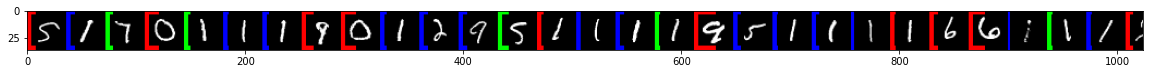

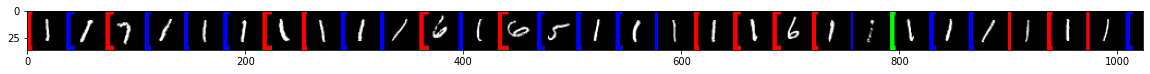

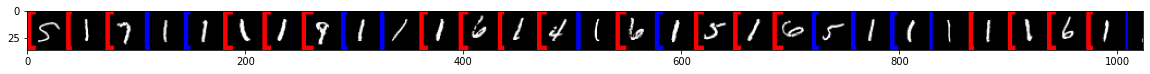

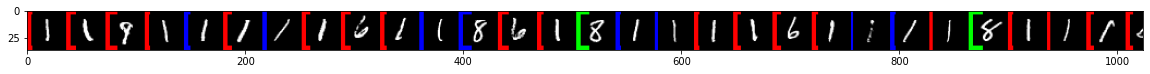

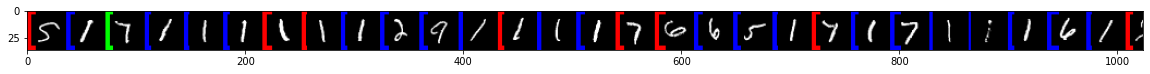

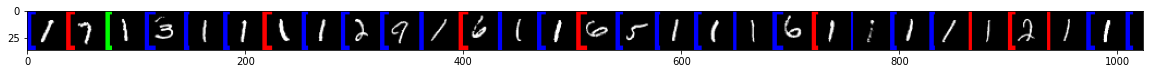

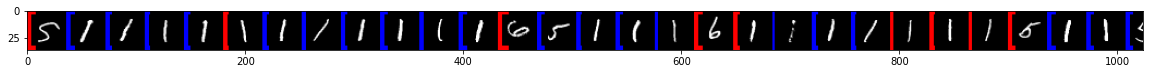

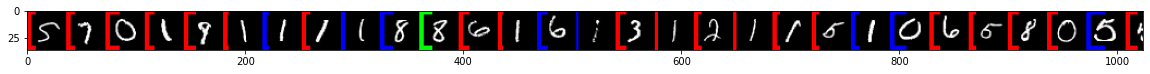

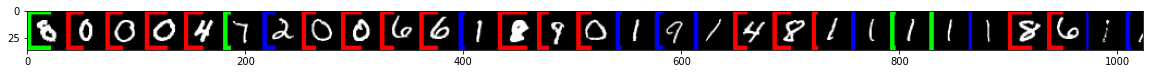

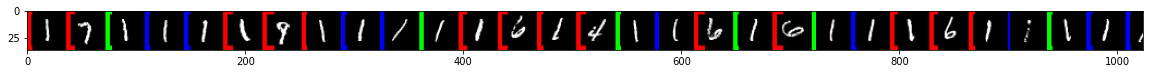

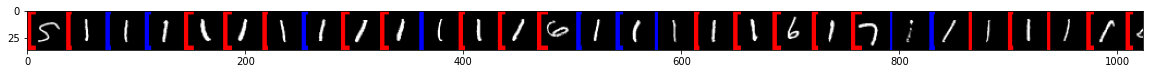

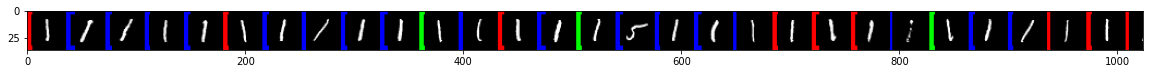

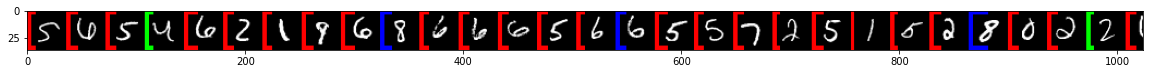

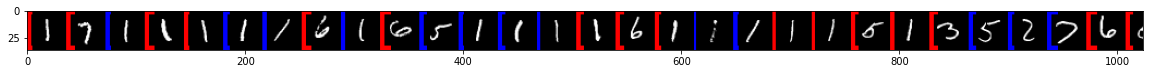

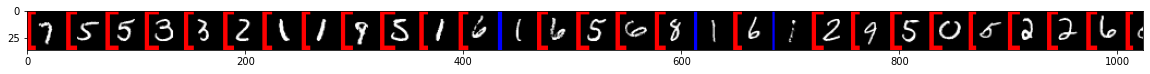

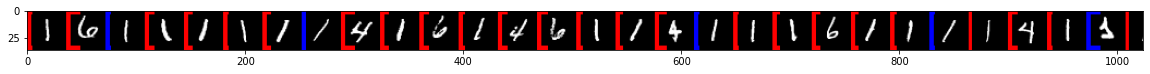

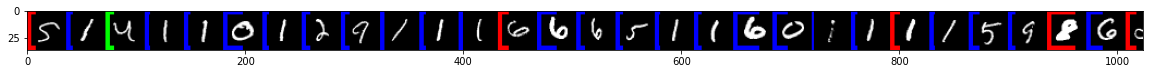

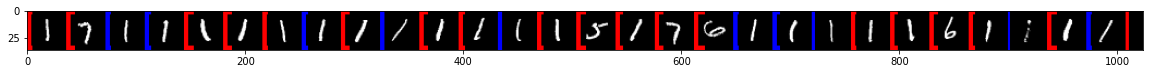

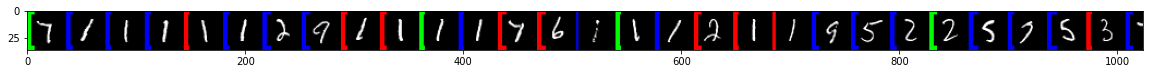

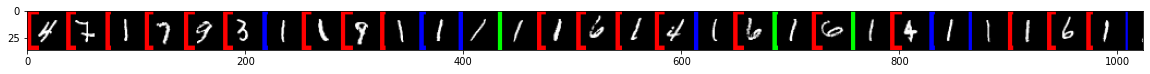

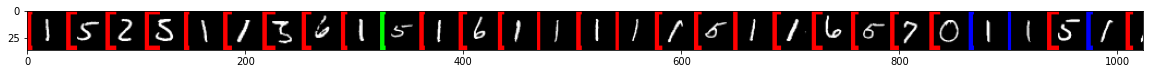

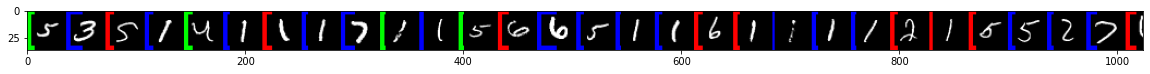

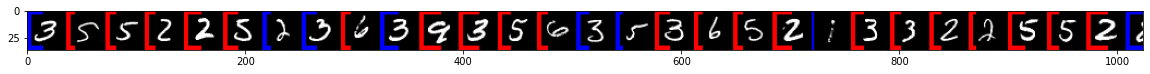

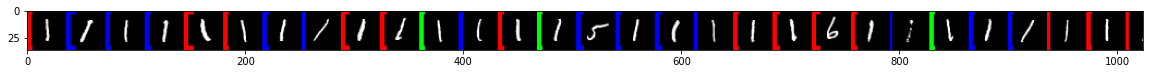

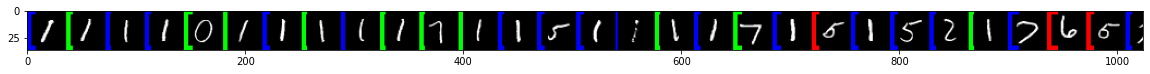

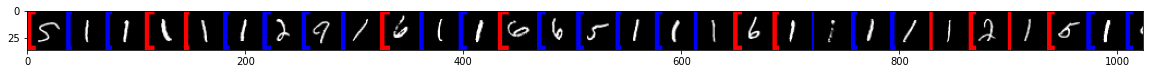

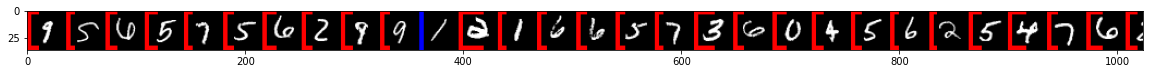

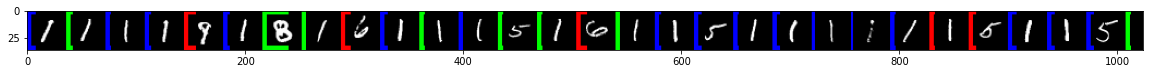

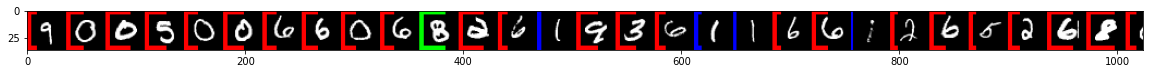

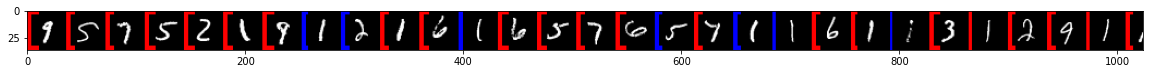

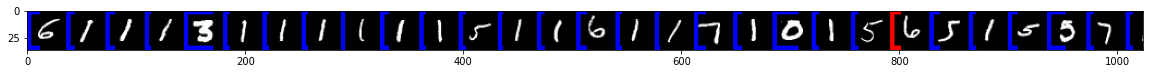

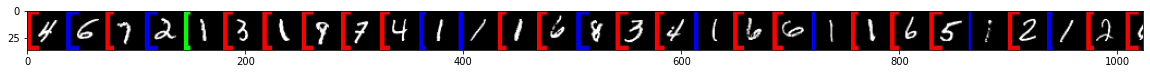

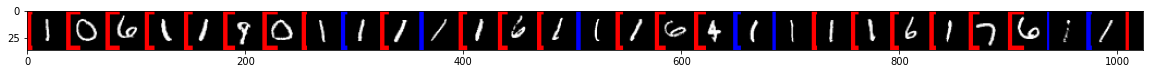

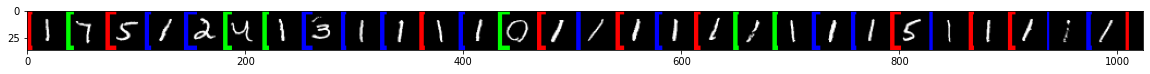

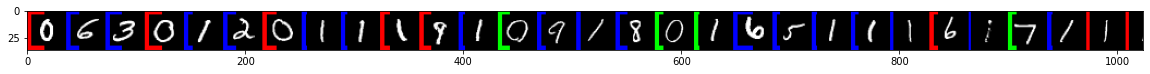

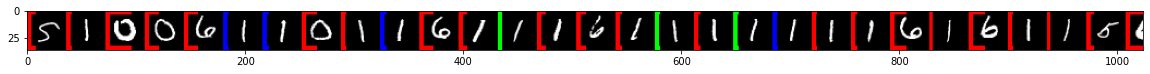

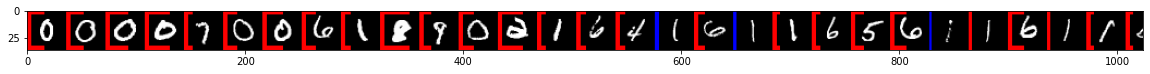

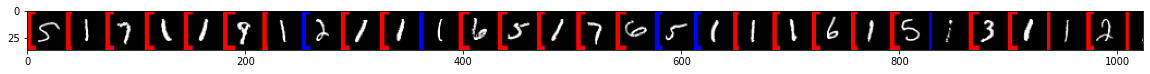

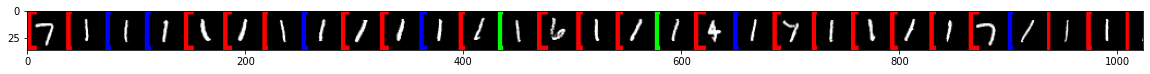

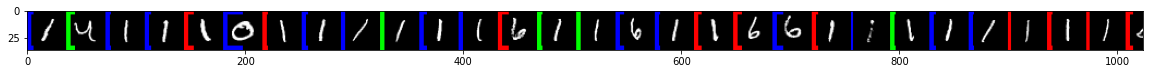

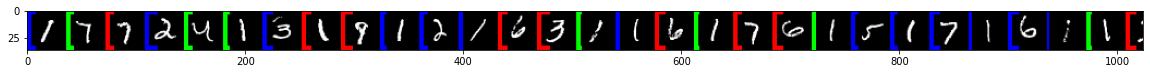

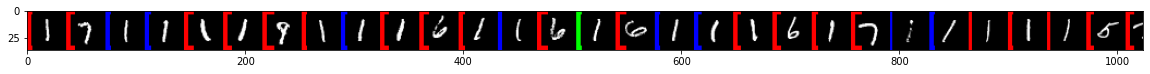

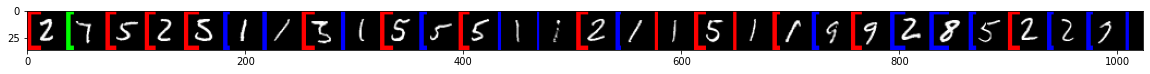

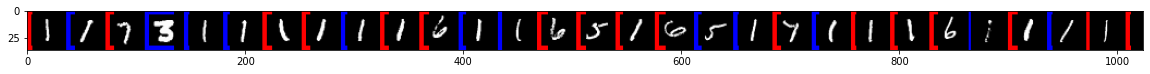

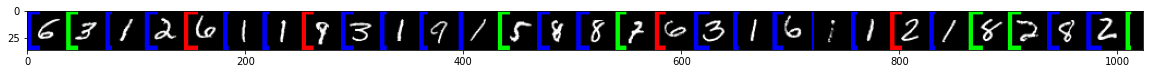

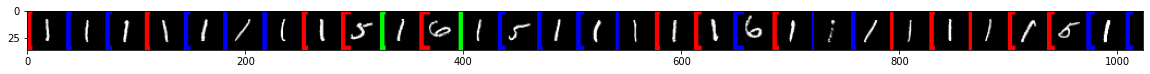

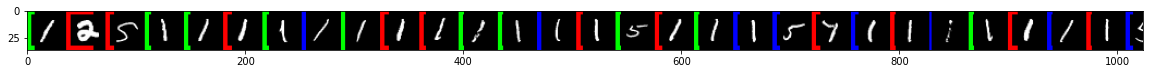

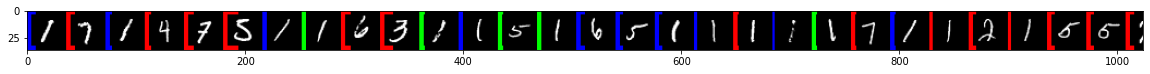

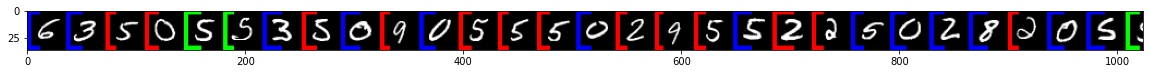

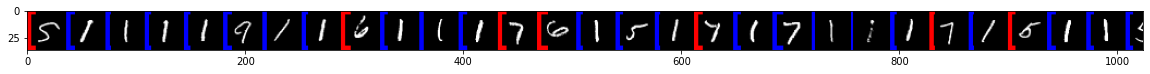

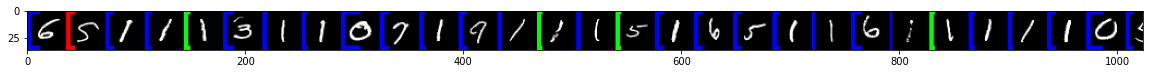

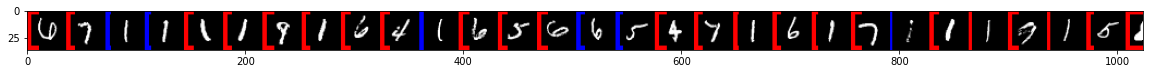

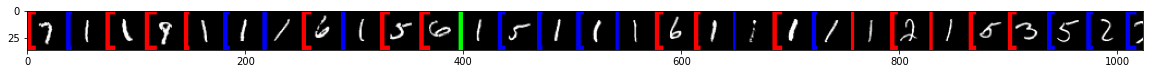

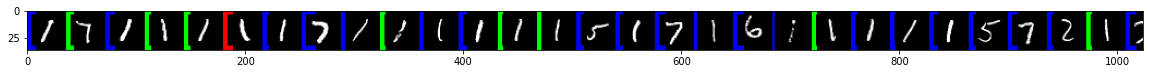

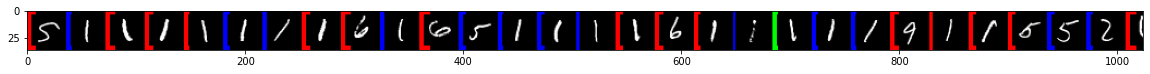

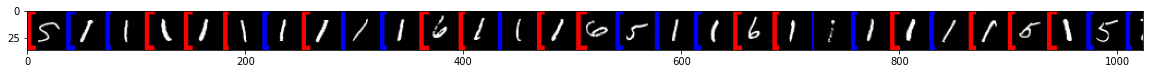

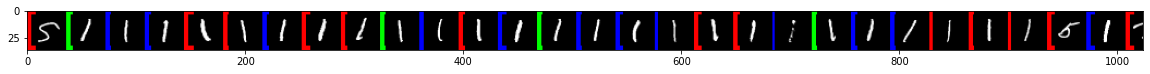

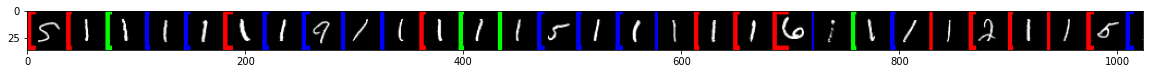

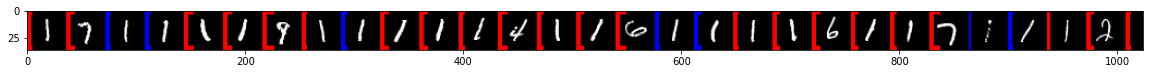

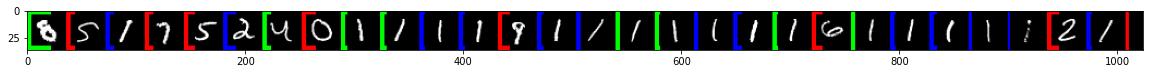

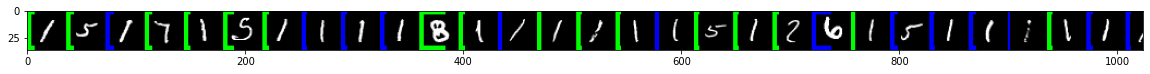

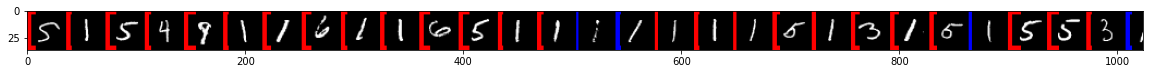

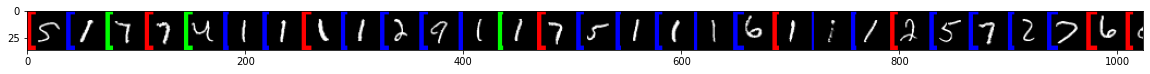

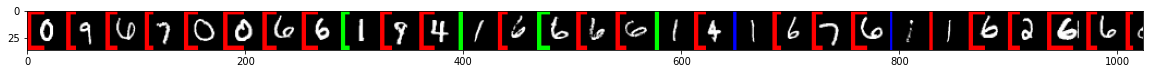

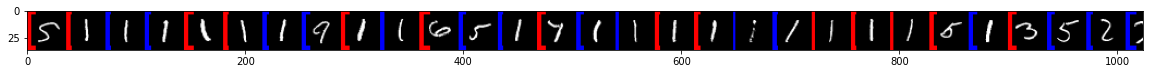

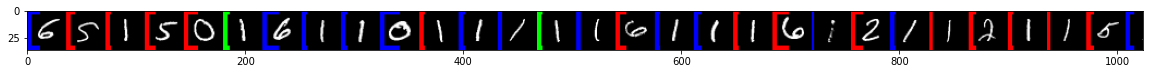

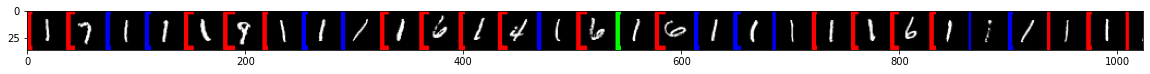

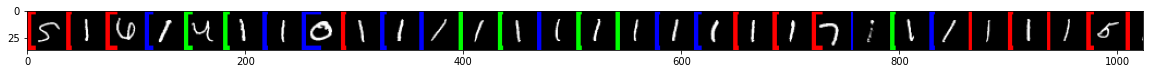

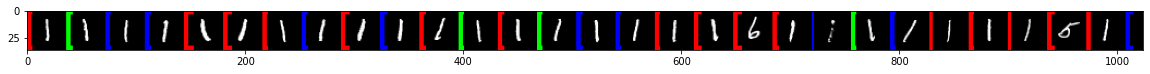

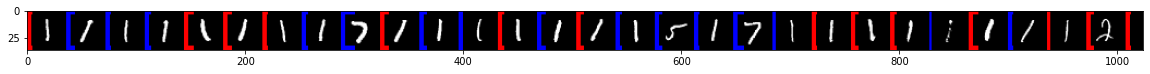

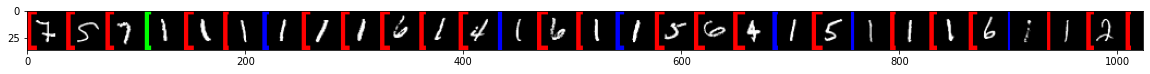

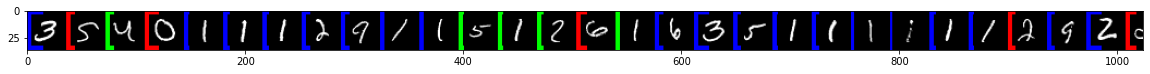

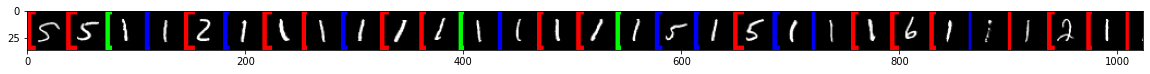

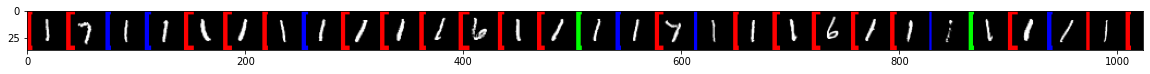

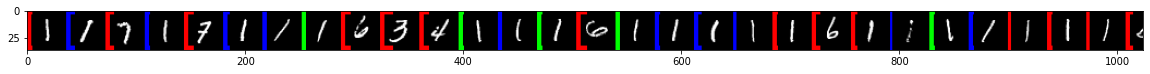

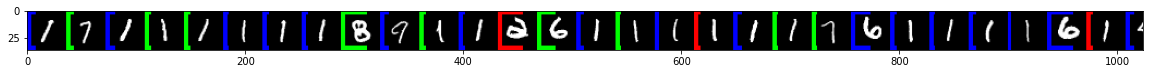

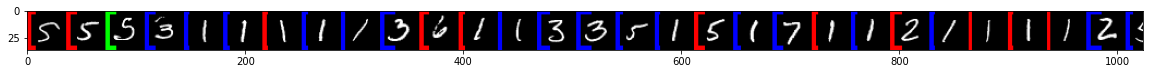

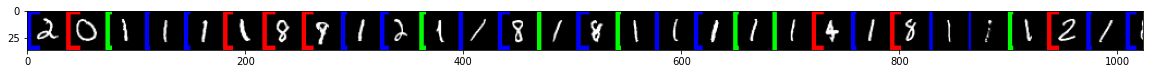

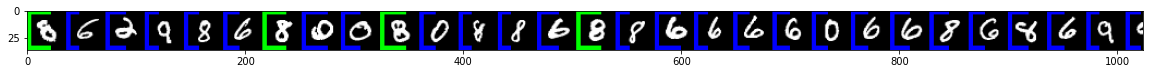

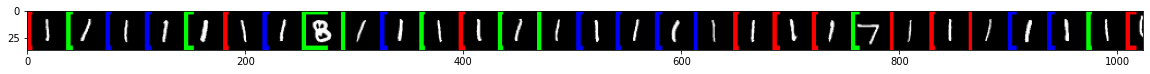

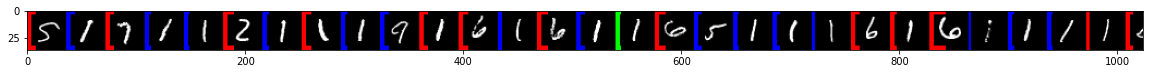

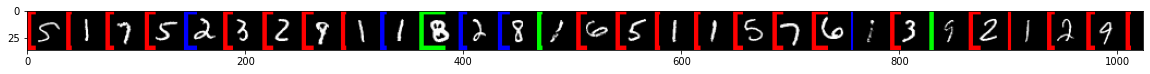

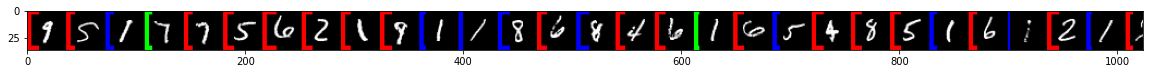

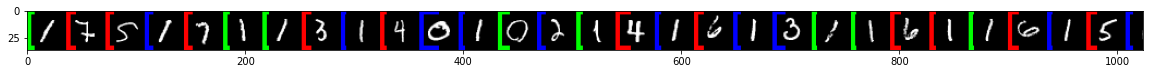

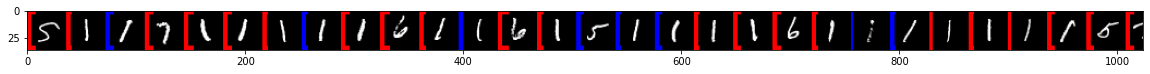

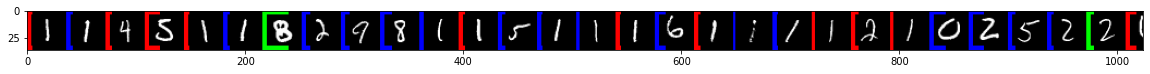

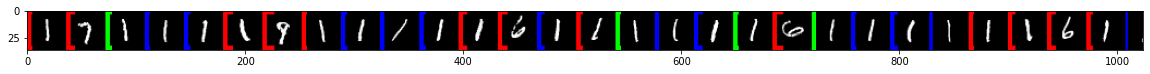

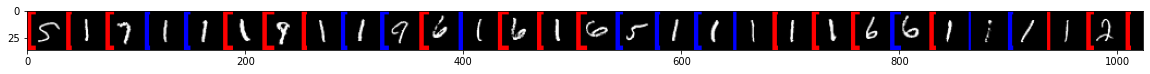

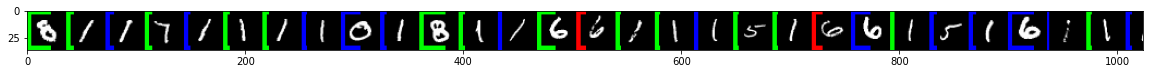

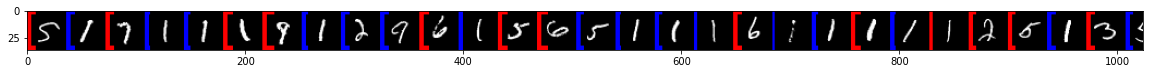

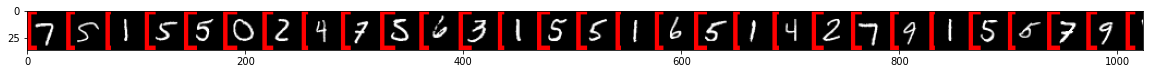

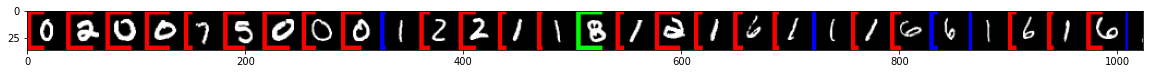

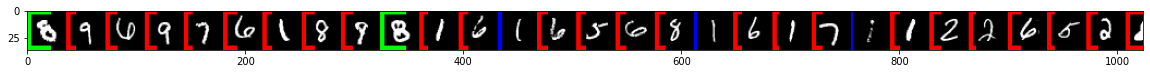

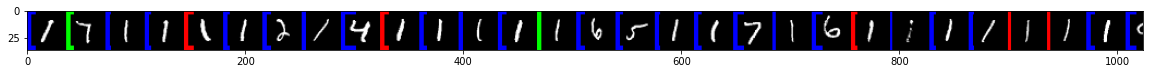

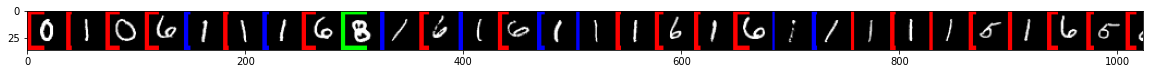

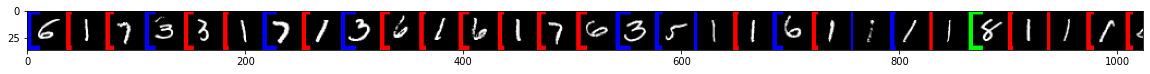

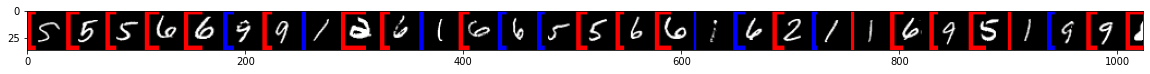

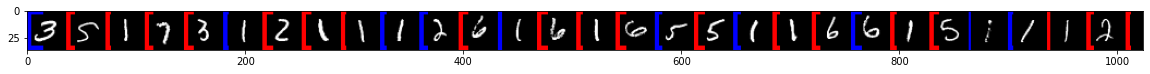

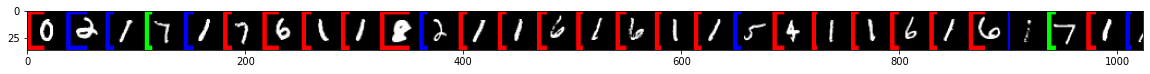

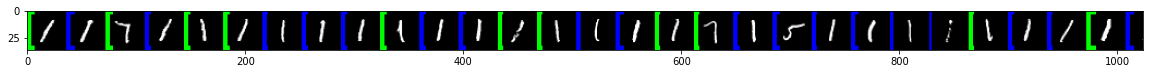

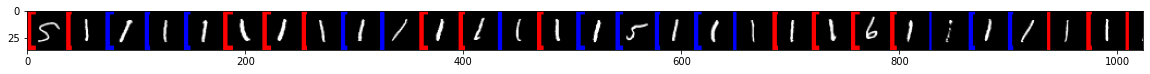

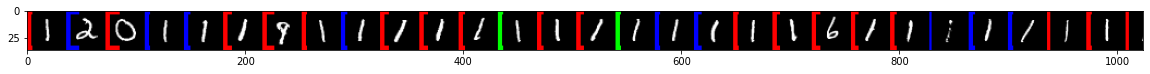

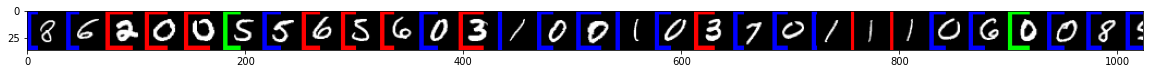

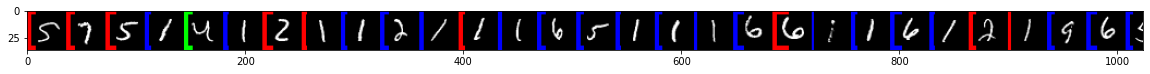

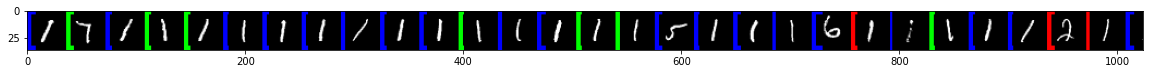

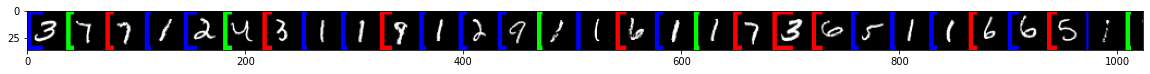

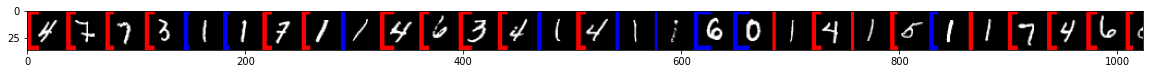

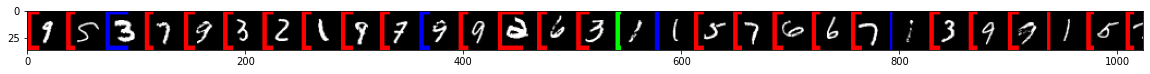

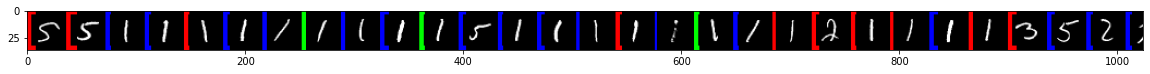

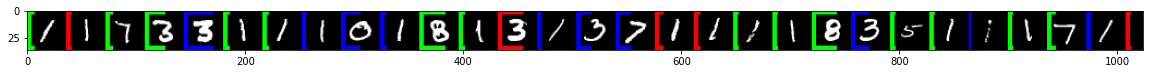

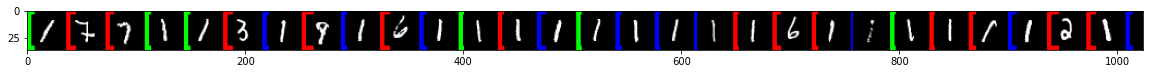

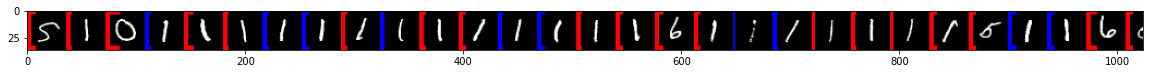

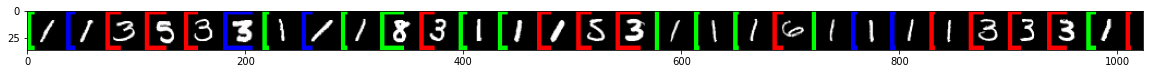

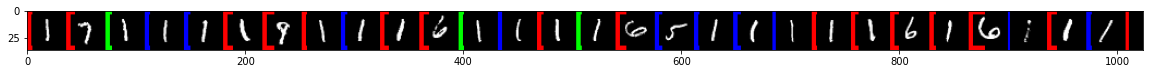

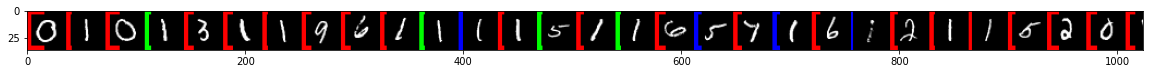

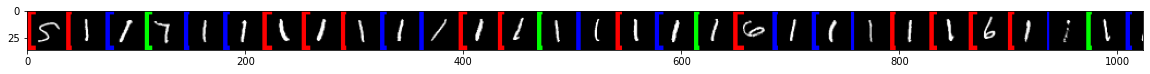

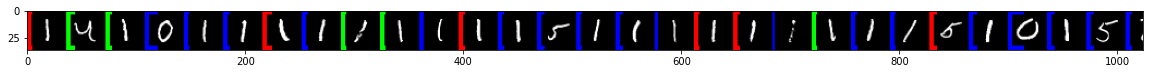

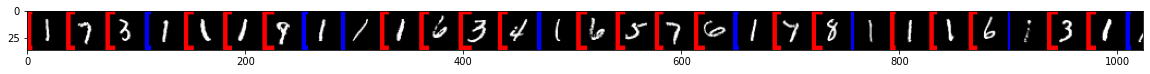

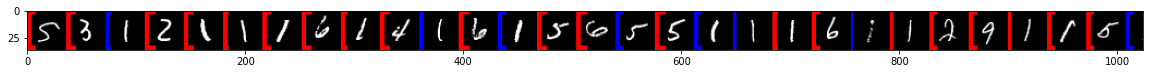

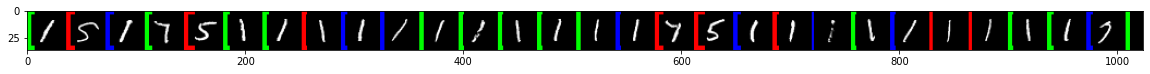

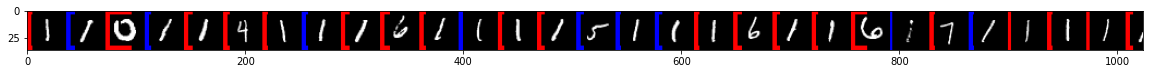

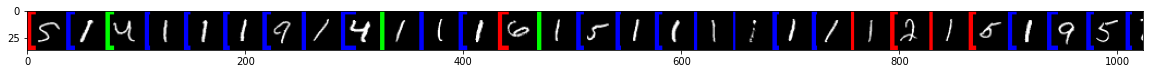

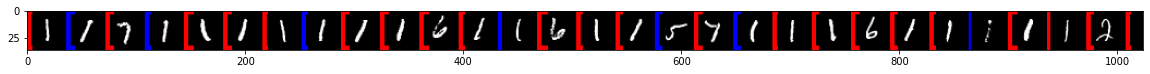

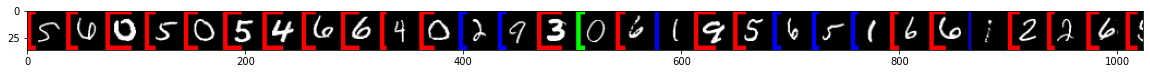

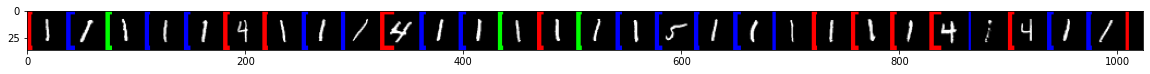

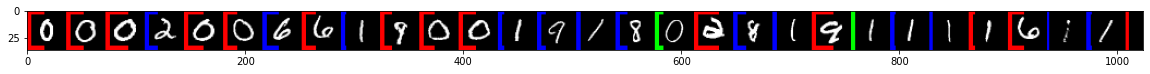

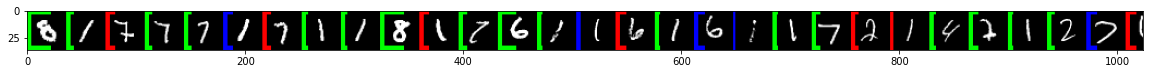

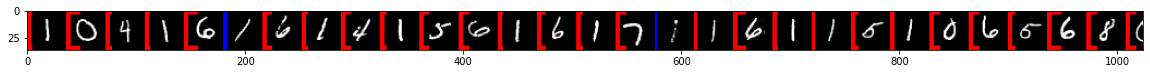

In [25]:
for c in range(ncc):
    print("Block {}".format(c))
#     grid = ImageGrid(fig, 111,  # similar to subplot(111)
#                      nrows_ncols=((blocks == c).sum(), 1),  # creates 2x2 grid of axes
#                      axes_pad=0.1,  # pad between axes in inch.
#                     )
    j = 0   
    for i, im_lst in enumerate(img_examples_pos):
        if blocks[i] == c:
            im = np.concatenate(im_lst.transpose(0, 2, 3, 1), axis=1)
            #grid[j].imshow(im[:, :1024])
            
            fig = plt.figure(figsize=(20., 20.))
            plt.imshow(im[:, :1024])
            plt.show()
            j+=1
            
    #plt.show()        
    fig.savefig(os.path.join(MODEL_DIR, "visualizations","block_{}_pos_img_examples.png".format(c)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


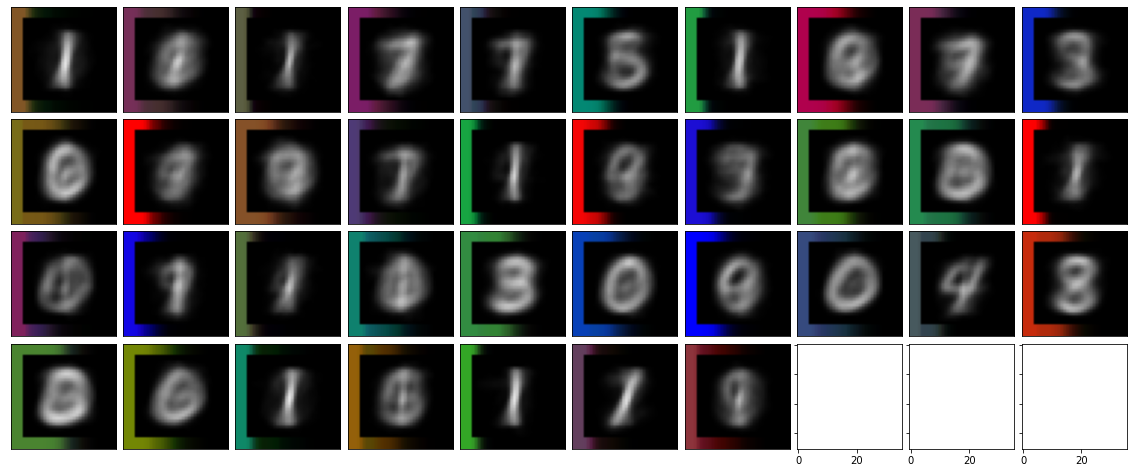

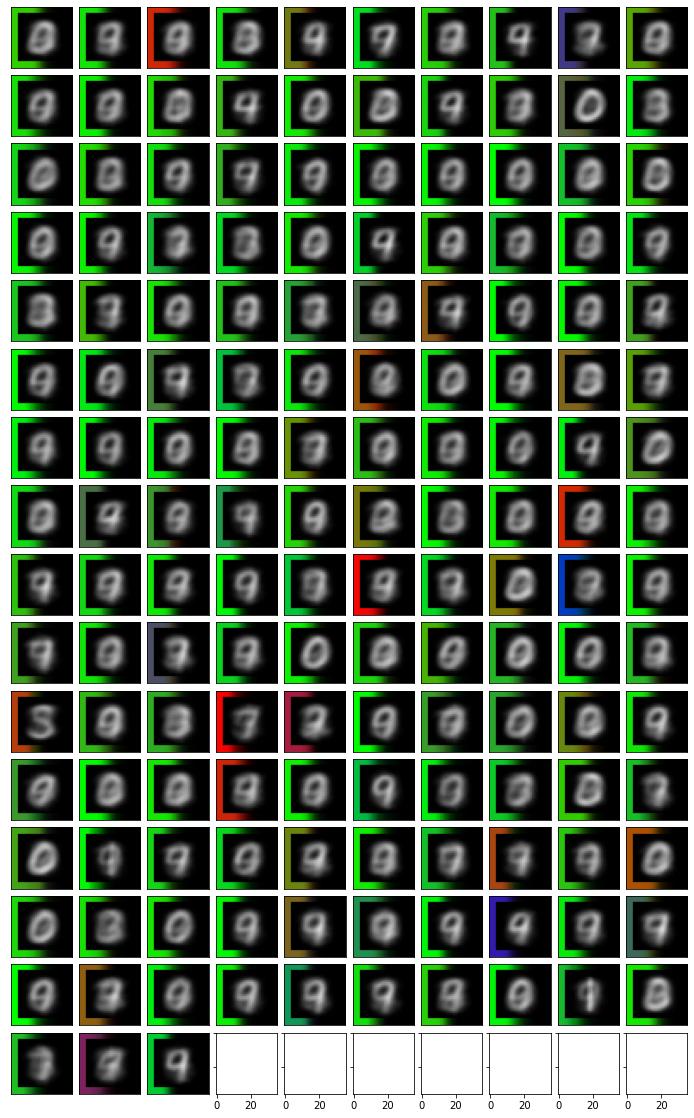

In [16]:
for c in range(ncc):
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(int(np.ceil((blocks==c).sum()/10)), 10),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                    )
                     
    for ax, im in zip(grid, weighted_images_neg_norm[blocks==c]):
        ax.imshow(im.transpose(1, 2, 0))
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    plt.show()
    fig.savefig(os.path.join(MODEL_DIR, "visualizations","block_{}_neg_imgs.png".format(c)))

floor_hue


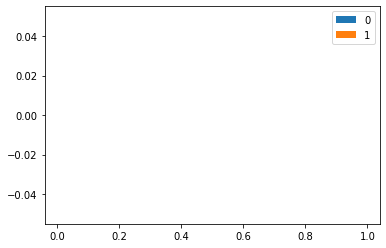

wall_hue


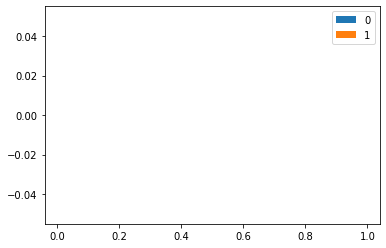

object_hue


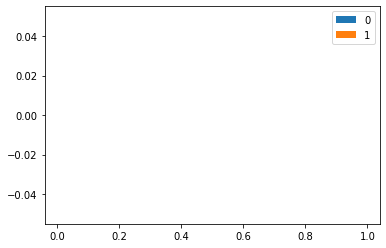

scale


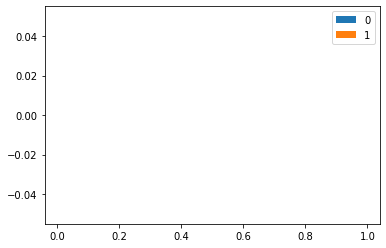

shape


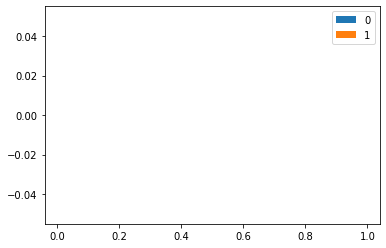

orientation


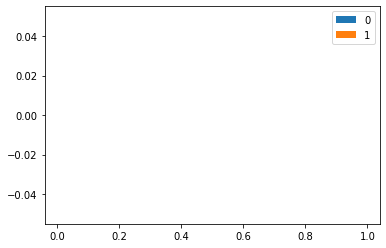

In [17]:
for i in range(6):
    print(_FACTORS_IN_ORDER[i])
    targets_neg_aggregate = list()
    for c in range(ncc):
        #print("Block {}".format(c+1))
        targets_neg_aggregate.append(np.zeros((0)))
        for j in range(layer_size):
            if blocks[j] == c:
                targets_neg_aggregate[c] = np.concatenate([targets_neg_aggregate[c], targets_neg[j][:, i]], axis=0)

    #print(targets_pos_aggregate)
    min_len = min(len(targets_neg_aggregate[c]) for c in range(ncc))
    targets_neg_aggregate_sample = [targets_neg_aggregate[c][:min_len] for c in range(ncc)]
    fig = plt.figure()
    plt.hist(np.array(targets_neg_aggregate_sample).transpose())
    plt.legend(range(ncc))
    plt.show()
    fig.savefig(os.path.join(MODEL_DIR, "visualizations","factor_{}_neg_factors_hist.png".format(i)))

In [18]:
&

# 0: floor_hue, 1: wall_hue, 2: object_hue, 3: scale, 4: shape, 5: orientation
#shapes: cylinder/cube, sphere, pill
#warmer colors: cyan, green, yellow, orange, red
#cooler colors: magenta, violet, blue

def target_vec_to_class(vec):
    labels = torch.zeros((vec.shape[0]))
    for i, v in enumerate(vec):
        if v[2] > 0.5: #object hue
            if v[0] > 0.5: #floor hue
                if v[5] > 0: #orientation
                    labels[i] = 7 #object of cooler color, cooler floor, orientation?
                else: #orientation
                    labels[i] = 6 #object of cooler color, cooler floor, orientation?
            else: #floor hue
                if v[4] > 1: #shape 
                    labels[i] = 5 #object of cooler color, warmer floor, pill or sphere
                else: #shape
                    labels[i] = 4 #object of cooler color, warmer floor, cylinder or cube
        else: #object hue
            if v[1] > 0.5: #wall hue
                if v[3] > 1: #scale
                    labels[i] = 3 #object of warmer color, cooler walls, bigger scale
                else: #scale
                    labels[i] = 2 #object of warmer color, cooler walls, smaller scale
            else:
                if v[4] > 2: #shape
                    labels[i] = 1 #object of warmer color, warmer walls, pill
                else: #shape
                    labels[i] = 0 #object of warmer color, warmer walls, sphere, cylinder or cube                   

    return labels.long()

SyntaxError: invalid syntax (1628354064.py, line 1)

In [ ]:
target_examples = [np.zeros((0, *img_shape)) for i in range(n_classes)]
for i, data in enumerate(trainloader):
    data, target = data[0], data[1]
    target = target_vec_to_class(target)
    for j in range(n_classes):
        target_examples[j]= np.concatenate([target_examples[j], data[target==j]], axis=0)
    
    if min(te.shape[0] for te in target_examples) > 9:
        break

In [ ]:
os.mkdir("outputs/dt_target_examples")

In [ ]:
for j in range(n_classes):
    print("Class {}".format(j))
    fig, axs = plt.subplots(nrows=3, ncols=3)
    for ax, te in zip(axs.flatten(), target_examples[j][:9]):
        ax.imshow(te.transpose(1, 2, 0))
    plt.show()
    fig.savefig("outputs/dt_target_examples/class_{}.png".format(j))
    